In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Replace the path the actual folder name
os.chdir("/content/drive/MyDrive/QBIO 401/QBIO 401 Project/Data")

# Confirm that the files are accessible
os.listdir()

Mounted at /content/drive


['switzerland.data',
 'cleveland.data',
 'processed.va.data',
 'reprocessed.hungarian.data',
 'new.data',
 'processed.hungarian.data',
 'hungarian.data',
 'long-beach-va.data',
 'processed.cleveland.data',
 'processed.switzerland.data']

In [55]:
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [3]:
!pip install abess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.2/493.2 kB 6.4 MB/s eta 0:00:00


# Data Processing 1 (removing all rows with null values)

In [56]:
column_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
df_hung = pd.read_csv('processed.hungarian.data', names=column_names, na_values="?")
df_va = pd.read_csv('processed.va.data', names=column_names, na_values="?")
df_clv = pd.read_csv('processed.cleveland.data', names=column_names, na_values="?")
df_sws = pd.read_csv('processed.switzerland.data', names=column_names, na_values="?")

df_hung.dropna(inplace=True)
df_va.dropna(inplace=True)
df_clv.dropna(inplace=True)
df_sws.dropna(inplace=True)

df = pd.concat([df_va, df_hung, df_clv, df_sws], ignore_index=True)
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

In [57]:
categorical_features = ["cp", "restecg", "thal", "slope", "ca", "sex", "fbs", "exang"]
df[categorical_features] = df[categorical_features].astype("category")
continuous_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

In [58]:
y = df['target']

# Set the remaining variables as the predictor matrix (X)
X = df.drop('target', axis=1)

### Best Subset Selection

In [59]:
import itertools
import patsy

def generate_interaction_formula(df, target, max_interaction_order=2):
    """
    Generate a Patsy-style formula with all interactions up to a specified order,
    excluding the target variable.

    Parameters:
        df (pd.DataFrame): DataFrame containing predictor variables.
        target (str): The name of the target variable (to exclude from predictors).
        max_interaction_order (int): Maximum order of interactions (default = 2 for pairwise).

    Returns:
        str: A Patsy-style formula string with main effects and interactions.
    """
    # Exclude the target variable
    predictors = [col for col in df.columns if col != target]

    # If only main effects (order=1), return them directly
    if max_interaction_order == 1:
        return " + ".join(predictors)

    # Generate main effects
    main_effects = " + ".join(predictors)

    # Generate interaction terms up to the specified order
    interactions = []
    for order in range(2, max_interaction_order + 1):  # Start from 2 (pairwise) to max order
        interactions.extend(
            [":".join(combo) for combo in itertools.combinations(predictors, order)]
        )

    # Combine main effects and interactions
    formula = f"{main_effects} + {' + '.join(interactions) if interactions else ''}"

    return formula

In [60]:
formula_full = generate_interaction_formula(df, "target", 1)
print(formula_full)

age + sex + cp + trestbps + chol + fbs + restecg + thalach + exang + oldpeak + slope + ca + thal


In [61]:
formula = f"target ~ {formula_full} - 1"  # The `- 1` removes the intercept

# Use `dmatrices` to create the design matrix (X) and response variable (y)
y, X = patsy.dmatrices(formula, df, return_type="dataframe")

In [62]:
from abess.linear import LogisticRegression

# Initialize the LogisticRegression model
logit_heart_best = LogisticRegression(path_type = "seq",
                                      support_size=range(0, X.shape[1] + 1),
                                      ic_type = "bic")

# Fit the model
logit_heart_best.fit(X, y)


# Get selected features
selected_features = np.where(logit_heart_best.coef_ != 0)[0]
print("Selected feature indices:", selected_features)

# Print selected feature names
print("Selected feature names:", X.columns.to_numpy()[selected_features])

Selected feature indices: [ 1  4  9 11 12 13 15 20]
Selected feature names: ['sex[1.0]' 'cp[T.4.0]' 'slope[T.2.0]' 'ca[T.1.0]' 'ca[T.2.0]' 'ca[T.3.0]'
 'thal[T.7.0]' 'oldpeak']


## Subset (BIC feature selection)

In [63]:
from sklearn.linear_model import LogisticRegression
y = df['target']

# Set the remaining variables as the predictor matrix (X)
X = df.drop('target', axis=1)

In [64]:
# prompt: drop all columns besides '"target" and these ['cp', 'oldpeak', 'thalach', 'thal', 'ca', 'fbs', 'sex', 'slope'] from df_train and df_test

cols_to_keep = ['cp', 'oldpeak', 'thalach', 'thal', 'ca', 'fbs', 'sex', 'slope']
X = X[cols_to_keep]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [66]:
X_train.head()

,cp,oldpeak,thalach,thal,ca,fbs,sex,slope
194,4.0,-0.136566,-1.053954,3.0,2.0,0.0,1.0,2.0
217,4.0,0.811038,-1.183924,3.0,2.0,0.0,0.0,2.0
186,3.0,-0.222711,1.935341,7.0,0.0,1.0,1.0,3.0
85,3.0,0.466455,0.029124,7.0,0.0,1.0,1.0,2.0
135,3.0,-0.739586,0.678970,3.0,0.0,0.0,0.0,2.0


In [67]:
# Define the parameter grid for alpha
param_grid = {'C': [0.1, 0.5, 5, 10, 50, 100], 'max_iter': [1000, 5000, 10000]} # C is the inverse of alpha

# Initialize the logistic regression model with LASSO penalty
logreg_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)

# Perform grid search with 5-fold stratified cross-validation
grid_search = GridSearchCV(logreg_lasso, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameter and the corresponding score
print("Best hyperparameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train the model with the best hyperparameter
model_bic = grid_search.best_estimator_
model_bic.fit(X_train, y_train)

Best hyperparameter: {'C': 5, 'max_iter': 1000}
Best score: 0.894191919191919


LogisticRegression(C=5, max_iter=1000, penalty='l1', solver='liblinear')

In [68]:
fpr_lasso_bic_2, tpr_lasso_bic_2, thresholds_lasso_bic_2 = roc_curve(y_test, model_bic.predict_proba(X_test)[:, 1])
auroc_lasso_bic_2 = roc_auc_score(y_test, model_bic.predict_proba(X_test)[:, 1])

In [69]:
# Define the parameter grid for alpha
param_grid = {'C': [0.1, 0.5, 5, 10, 50, 100], 'max_iter': [1000, 5000, 10000]} # C is the inverse of alpha

# Initialize the logistic regression model with Ridge penalty
logreg_lasso = LogisticRegression(penalty='l2', solver='liblinear', max_iter=10000)

# Perform grid search with 5-fold stratified cross-validation
grid_search = GridSearchCV(logreg_lasso, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameter and the corresponding score
print("Best hyperparameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train the model with the best hyperparameter
model_bic = grid_search.best_estimator_
model_bic.fit(X_train, y_train)

Best hyperparameter: {'C': 5, 'max_iter': 1000}
Best score: 0.8979797979797979


LogisticRegression(C=5, max_iter=1000, solver='liblinear')

In [70]:
fpr_ridge_bic_2, tpr_ridge_bic_2, thresholds_ridge_bic_2 = roc_curve(y_test, model_bic.predict_proba(X_test)[:, 1])
auroc_ridge_bic_2 = roc_auc_score(y_test, model_bic.predict_proba(X_test)[:, 1])

## Subset (from paper)

In [72]:
y = df['target']

# Set the remaining variables as the predictor matrix (X)
X = df.drop('target', axis=1)

In [73]:
cols_to_keep = ['cp', 'ca', 'thal']
X = X[cols_to_keep]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [75]:
X_train.head()

,cp,ca,thal
194,4.0,2.0,3.0
217,4.0,2.0,3.0
186,3.0,0.0,7.0
85,3.0,0.0,7.0
135,3.0,0.0,3.0


In [76]:
# Define the parameter grid for alpha
param_grid = {'C': [0.1, 0.5, 5, 10, 50, 100], 'max_iter': [1000, 5000, 10000]} # C is the inverse of alpha

# Initialize the logistic regression model with LASSO penalty
logreg_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)

# Perform grid search with 5-fold stratified cross-validation
grid_search = GridSearchCV(logreg_lasso, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameter and the corresponding score
print("Best hyperparameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train the model with the best hyperparameter
model_paper = grid_search.best_estimator_
model_paper.fit(X_train, y_train)

Best hyperparameter: {'C': 0.5, 'max_iter': 1000}
Best score: 0.8592003367003367


LogisticRegression(C=0.5, max_iter=1000, penalty='l1', solver='liblinear')

In [77]:
fpr_lasso_paper_2, tpr_lasso_paper_2, thresholds_lasso_paper_2 = roc_curve(y_test, model_paper.predict_proba(X_test)[:, 1])
auroc_lasso_paper_2 = roc_auc_score(y_test, model_paper.predict_proba(X_test)[:, 1])

In [78]:
# Define the parameter grid for alpha
param_grid = {'C': [0.1, 0.5, 5, 10, 50, 100], 'max_iter': [1000, 5000, 10000]} # C is the inverse of alpha

# Initialize the logistic regression model with Ridge penalty
logreg_lasso = LogisticRegression(penalty='l2', solver='liblinear', max_iter=10000)

# Perform grid search with 5-fold stratified cross-validation
grid_search = GridSearchCV(logreg_lasso, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameter and the corresponding score
print("Best hyperparameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train the model with the best hyperparameter
model_paper = grid_search.best_estimator_
model_paper.fit(X_train, y_train)

Best hyperparameter: {'C': 0.5, 'max_iter': 1000}
Best score: 0.8629377104377104


LogisticRegression(C=0.5, max_iter=1000, solver='liblinear')

In [79]:
fpr_ridge_paper_2, tpr_ridge_paper_2, thresholds_ridge_paper_2 = roc_curve(y_test, model_paper.predict_proba(X_test)[:, 1])
auroc_ridge_paper_2 = roc_auc_score(y_test, model_paper.predict_proba(X_test)[:, 1])

## Subset (Best Subset Selection w/ BIC criteria)

In [80]:
y = df['target']

# Set the remaining variables as the predictor matrix (X)
X = df.drop('target', axis=1)

In [81]:
cols_to_keep = ["sex", "cp", "slope", "ca", "thal", "oldpeak"]
X = X[cols_to_keep]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [83]:
X_train.head()

,sex,cp,slope,ca,thal,oldpeak
194,1.0,4.0,2.0,2.0,3.0,-0.136566
217,0.0,4.0,2.0,2.0,3.0,0.811038
186,1.0,3.0,3.0,0.0,7.0,-0.222711
85,1.0,3.0,2.0,0.0,7.0,0.466455
135,0.0,3.0,2.0,0.0,3.0,-0.739586


In [84]:
# Define the parameter grid for alpha
param_grid = {'C': [0.1, 0.5, 5, 10, 50, 100], 'max_iter': [1000, 5000, 10000]} # C is the inverse of alpha

# Initialize the logistic regression model with LASSO penalty
logreg_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)

# Perform grid search with 5-fold stratified cross-validation
grid_search = GridSearchCV(logreg_lasso, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameter and the corresponding score
print("Best hyperparameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train the model with the best hyperparameter
model_bagging = grid_search.best_estimator_
model_bagging.fit(X_train, y_train)

Best hyperparameter: {'C': 5, 'max_iter': 1000}
Best score: 0.8878282828282827


LogisticRegression(C=5, max_iter=1000, penalty='l1', solver='liblinear')

In [85]:
fpr_lasso_bagging_2, tpr_lasso_bagging_2, thresholds_lasso_bagging_2 = roc_curve(y_test, model_bagging.predict_proba(X_test)[:, 1])
auroc_lasso_bagging_2 = roc_auc_score(y_test, model_bagging.predict_proba(X_test)[:, 1])

In [86]:
# Define the parameter grid for alpha
param_grid = {'C': [0.1, 0.5, 5, 10, 50, 100], 'max_iter': [1000, 5000, 10000]} # C is the inverse of alpha

# Initialize the logistic regression model with Ridge penalty
logreg_lasso = LogisticRegression(penalty='l2', solver='liblinear', max_iter=10000)

# Perform grid search with 5-fold stratified cross-validation
grid_search = GridSearchCV(logreg_lasso, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameter and the corresponding score
print("Best hyperparameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train the model with the best hyperparameter
model_bagging = grid_search.best_estimator_
model_bagging.fit(X_train, y_train)

Best hyperparameter: {'C': 100, 'max_iter': 1000}
Best score: 0.8878282828282827


LogisticRegression(C=100, max_iter=1000, solver='liblinear')

In [87]:
fpr_ridge_bagging_2, tpr_ridge_bagging_2, thresholds_ridge_bagging_2 = roc_curve(y_test, model_bagging.predict_proba(X_test)[:, 1])
auroc_ridge_bagging_2 = roc_auc_score(y_test, model_bagging.predict_proba(X_test)[:, 1])

## Model Evaluation

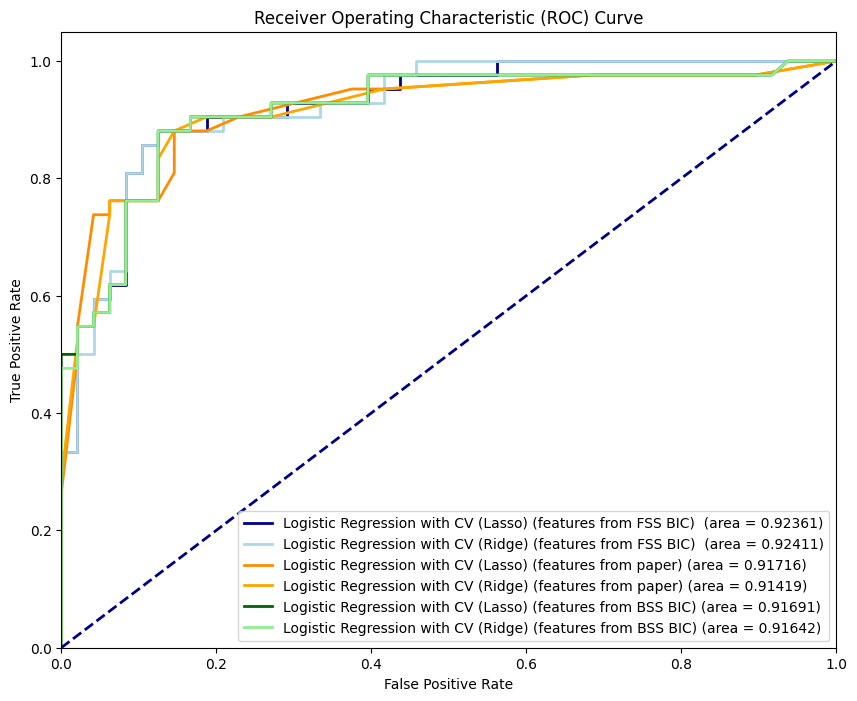

In [88]:
fontsize = 10
plt.rcParams.update({'font.size': fontsize})
plt.figure(figsize=(10, 8))

plt.plot(fpr_lasso_bic_2, tpr_lasso_bic_2, color='darkblue', lw=2, label=f'Logistic Regression with CV (Lasso) (features from FSS BIC)  (area = {auroc_lasso_bic_2:.5f})')
plt.plot(fpr_ridge_bic_2, tpr_ridge_bic_2, color='lightblue', lw=2, label=f'Logistic Regression with CV (Ridge) (features from FSS BIC)  (area = {auroc_ridge_bic_2:.5f})')

plt.plot(fpr_lasso_paper_2, tpr_lasso_paper_2, color='darkorange', lw=2, label=f'Logistic Regression with CV (Lasso) (features from paper) (area = {auroc_lasso_paper_2:.5f})')
plt.plot(fpr_ridge_paper_2, tpr_ridge_paper_2, color='orange', lw=2, label=f'Logistic Regression with CV (Ridge) (features from paper) (area = {auroc_ridge_paper_2:.5f})')


plt.plot(fpr_lasso_bagging_2, tpr_lasso_bagging_2, color='darkgreen', lw=2, label=f'Logistic Regression with CV (Lasso) (features from BSS BIC) (area = {auroc_lasso_bagging_2:.5f})')
plt.plot(fpr_ridge_bagging_2, tpr_ridge_bagging_2, color='lightgreen', lw=2, label=f'Logistic Regression with CV (Ridge) (features from BSS BIC) (area = {auroc_ridge_bagging_2:.5f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Data Processing 2 (treating all null values with mean or new class)

In [89]:
column_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
df_hung = pd.read_csv('processed.hungarian.data', names=column_names, na_values="?")
df_va = pd.read_csv('processed.va.data', names=column_names, na_values="?")
df_clv = pd.read_csv('processed.cleveland.data', names=column_names, na_values="?")
df_sws = pd.read_csv('processed.switzerland.data', names=column_names, na_values="?")

df = pd.concat([df_va, df_hung, df_clv, df_sws], ignore_index=True)
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
numeric_cols = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Define categorical columns (excluding the target variable)
categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]

# Fill null values in categorical columns with "Unknown"
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")

for col in categorical_cols:
    if "Unknown" in df[col].unique():
        df.loc[df[col] == "Unknown", col] = df[col].nunique() +1
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [90]:
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
df[categorical_features] = df[categorical_features].astype("category")
continuous_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

In [91]:
y = df['target']

# Set the remaining variables as the predictor matrix (X)
X = df.drop('target', axis=1)

## Subset (BIC feature selection)

In [92]:
y = df['target']

# Set the remaining variables as the predictor matrix (X)
X = df.drop('target', axis=1)

In [93]:
# prompt: drop all columns besides '"target" and these ['cp', 'oldpeak', 'thalach', 'thal', 'ca', 'fbs', 'sex', 'slope'] from df_train and df_test

cols_to_keep = ['cp', 'oldpeak', 'thalach', 'thal', 'ca', 'fbs', 'sex', 'slope']
X = X[cols_to_keep]

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [95]:
X_train.head()

,cp,oldpeak,thalach,thal,ca,fbs,sex,slope
547,2.0,-0.834397,2.008146,3,0.000000,0.0,1.0,1.0
454,4.0,1.064576,-1.494365,5,0.676375,0.0,1.0,2.0
512,3.0,-0.644500,0.057884,3,0.000000,0.0,0.0,1.0
293,3.0,-0.834397,-0.499333,5,0.676375,0.0,0.0,5.0
357,2.0,-0.834397,0.694705,5,0.676375,0.0,0.0,5.0


In [96]:
y_train.head()

,target
547,0
454,1
512,0
293,0
357,0


In [97]:
# Define the parameter grid for alpha
param_grid = {'C': [0.1, 0.5, 5, 10, 50, 100], 'max_iter': [1000, 5000, 10000]} # C is the inverse of alpha

# Initialize the logistic regression model with LASSO penalty
logreg_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)

# Perform grid search with 5-fold stratified cross-validation
grid_search = GridSearchCV(logreg_lasso, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameter and the corresponding score
print("Best hyperparameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train the model with the best hyperparameter
model_bic = grid_search.best_estimator_
model_bic.fit(X_train, y_train)

best_model_2 = model_bic
best_model_2.fit(X_train, y_train)

Best hyperparameter: {'C': 5, 'max_iter': 1000}
Best score: 0.889033251231527


LogisticRegression(C=5, max_iter=1000, penalty='l1', solver='liblinear')

In [98]:
fpr_lasso_bic_2, tpr_lasso_bic_2, thresholds_lasso_bic_2 = roc_curve(y_test, model_bic.predict_proba(X_test)[:, 1])
auroc_lasso_bic_2 = roc_auc_score(y_test, model_bic.predict_proba(X_test)[:, 1])

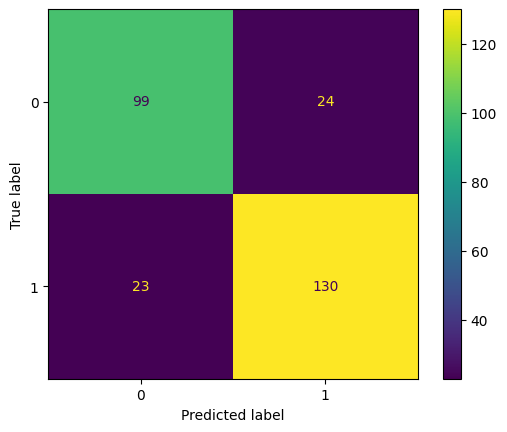

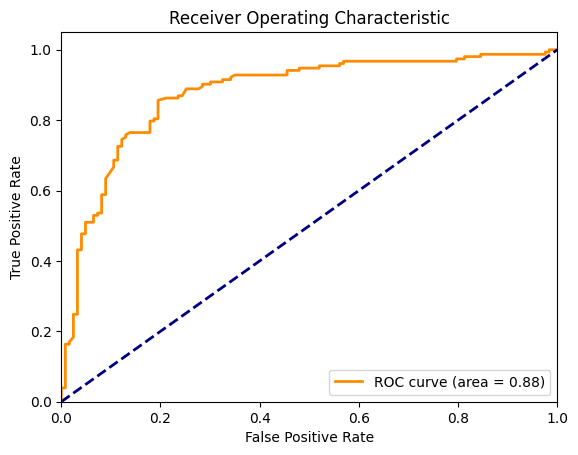

Precision: 0.8441558441558441
Recall: 0.8496732026143791
ROC AUC Score: 0.8768531802965088


In [99]:
# Predict probabilities for the test set
y_pred_prob = best_model_2.predict_proba(X_test)[:, 1]

# Predict class labels for the test set
y_pred = best_model_2.predict(X_test)

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot()
plt.show()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC AUC Score: {roc_auc}")


In [100]:
# Define the parameter grid for alpha
param_grid = {'C': [0.1, 0.5, 5, 10, 50, 100], 'max_iter': [1000, 5000, 10000]} # C is the inverse of alpha

# Initialize the logistic regression model with Ridge penalty
logreg_lasso = LogisticRegression(penalty='l2', solver='liblinear', max_iter=10000)

# Perform grid search with 5-fold stratified cross-validation
grid_search = GridSearchCV(logreg_lasso, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameter and the corresponding score
print("Best hyperparameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train the model with the best hyperparameter
model_bic = grid_search.best_estimator_
model_bic.fit(X_train, y_train)

Best hyperparameter: {'C': 5, 'max_iter': 1000}
Best score: 0.8893048713738368


LogisticRegression(C=5, max_iter=1000, solver='liblinear')

In [101]:
fpr_ridge_bic_2, tpr_ridge_bic_2, thresholds_ridge_bic_2 = roc_curve(y_test, model_bic.predict_proba(X_test)[:, 1])
auroc_ridge_bic_2 = roc_auc_score(y_test, model_bic.predict_proba(X_test)[:, 1])

## Subset (from paper)

In [102]:
y = df['target']

# Set the remaining variables as the predictor matrix (X)
X = df.drop('target', axis=1)

In [103]:
cols_to_keep = ['cp', 'ca', 'thal']
X = X[cols_to_keep]

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [105]:
X_train.head()

,cp,ca,thal
547,2.0,0.000000,3
454,4.0,0.676375,5
512,3.0,0.000000,3
293,3.0,0.676375,5
357,2.0,0.676375,5


In [106]:
# Define the parameter grid for alpha
param_grid = {'C': [0.1, 0.5, 5, 10, 50, 100], 'max_iter': [1000, 5000, 10000]} # C is the inverse of alpha

# Initialize the logistic regression model with LASSO penalty
logreg_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)

# Perform grid search with 5-fold stratified cross-validation
grid_search = GridSearchCV(logreg_lasso, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameter and the corresponding score
print("Best hyperparameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train the model with the best hyperparameter
model_paper = grid_search.best_estimator_
model_paper.fit(X_train, y_train)

Best hyperparameter: {'C': 10, 'max_iter': 1000}
Best score: 0.8360231937602627


LogisticRegression(C=10, max_iter=1000, penalty='l1', solver='liblinear')

In [107]:
fpr_lasso_paper_2, tpr_lasso_paper_2, thresholds_lasso_paper_2 = roc_curve(y_test, model_paper.predict_proba(X_test)[:, 1])
auroc_lasso_paper_2 = roc_auc_score(y_test, model_paper.predict_proba(X_test)[:, 1])

In [108]:
# Define the parameter grid for alpha
param_grid = {'C': [0.1, 0.5, 5, 10, 50, 100], 'max_iter': [1000, 5000, 10000]} # C is the inverse of alpha

# Initialize the logistic regression model with Ridge penalty
logreg_lasso = LogisticRegression(penalty='l2', solver='liblinear', max_iter=10000)

# Perform grid search with 5-fold stratified cross-validation
grid_search = GridSearchCV(logreg_lasso, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameter and the corresponding score
print("Best hyperparameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train the model with the best hyperparameter
model_paper = grid_search.best_estimator_
model_paper.fit(X_train, y_train)

Best hyperparameter: {'C': 10, 'max_iter': 1000}
Best score: 0.836218185550082


LogisticRegression(C=10, max_iter=1000, solver='liblinear')

In [109]:
fpr_ridge_paper_2, tpr_ridge_paper_2, thresholds_ridge_paper_2 = roc_curve(y_test, model_paper.predict_proba(X_test)[:, 1])
auroc_ridge_paper_2 = roc_auc_score(y_test, model_paper.predict_proba(X_test)[:, 1])

## Subset (bagging features)

In [110]:
y = df['target']

# Set the remaining variables as the predictor matrix (X)
X = df.drop('target', axis=1)

In [111]:
cols_to_keep = ["sex", "cp", "slope", "ca", "thal", "oldpeak"]
X = X[cols_to_keep]

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [113]:
X_train.head()

,sex,cp,slope,ca,thal,oldpeak
547,1.0,2.0,1.0,0.000000,3,-0.834397
454,1.0,4.0,2.0,0.676375,5,1.064576
512,0.0,3.0,1.0,0.000000,3,-0.644500
293,0.0,3.0,5.0,0.676375,5,-0.834397
357,0.0,2.0,5.0,0.676375,5,-0.834397


In [114]:
# Define the parameter grid for alpha
param_grid = {'C': [0.1, 0.5, 5, 10, 50, 100], 'max_iter': [1000, 5000, 10000]} # C is the inverse of alpha

# Initialize the logistic regression model with LASSO penalty
logreg_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)

# Perform grid search with 5-fold stratified cross-validation
grid_search = GridSearchCV(logreg_lasso, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameter and the corresponding score
print("Best hyperparameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train the model with the best hyperparameter
model_bagging = grid_search.best_estimator_
model_bagging.fit(X_train, y_train)

Best hyperparameter: {'C': 0.5, 'max_iter': 1000}
Best score: 0.8654361658456488


LogisticRegression(C=0.5, max_iter=1000, penalty='l1', solver='liblinear')

In [115]:
fpr_lasso_bagging_2, tpr_lasso_bagging_2, thresholds_lasso_bagging_2 = roc_curve(y_test, model_bagging.predict_proba(X_test)[:, 1])
auroc_lasso_bagging_2 = roc_auc_score(y_test, model_bagging.predict_proba(X_test)[:, 1])

In [116]:
# Define the parameter grid for alpha
param_grid = {'C': [0.1, 0.5, 5, 10, 50, 100], 'max_iter': [1000, 5000, 10000]} # C is the inverse of alpha

# Initialize the logistic regression model with Ridge penalty
logreg_lasso = LogisticRegression(penalty='l2', solver='liblinear', max_iter=10000)

# Perform grid search with 5-fold stratified cross-validation
grid_search = GridSearchCV(logreg_lasso, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameter and the corresponding score
print("Best hyperparameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train the model with the best hyperparameter
model_bagging = grid_search.best_estimator_
model_bagging.fit(X_train, y_train)

Best hyperparameter: {'C': 10, 'max_iter': 1000}
Best score: 0.8672649835796389


LogisticRegression(C=10, max_iter=1000, solver='liblinear')

In [117]:
fpr_ridge_bagging_2, tpr_ridge_bagging_2, thresholds_ridge_bagging_2 = roc_curve(y_test, model_bagging.predict_proba(X_test)[:, 1])
auroc_ridge_bagging_2 = roc_auc_score(y_test, model_bagging.predict_proba(X_test)[:, 1])

## Model Evaluation

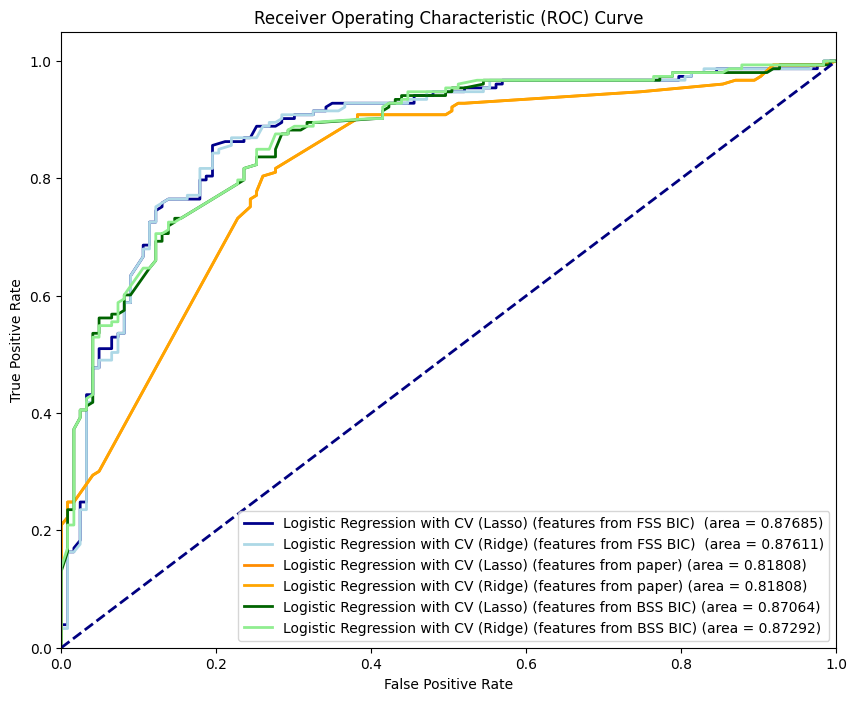

In [118]:
fontsize = 10
plt.rcParams.update({'font.size': fontsize})
plt.figure(figsize=(10, 8))

plt.plot(fpr_lasso_bic_2, tpr_lasso_bic_2, color='darkblue', lw=2, label=f'Logistic Regression with CV (Lasso) (features from FSS BIC)  (area = {auroc_lasso_bic_2:.5f})')
plt.plot(fpr_ridge_bic_2, tpr_ridge_bic_2, color='lightblue', lw=2, label=f'Logistic Regression with CV (Ridge) (features from FSS BIC)  (area = {auroc_ridge_bic_2:.5f})')

plt.plot(fpr_lasso_paper_2, tpr_lasso_paper_2, color='darkorange', lw=2, label=f'Logistic Regression with CV (Lasso) (features from paper) (area = {auroc_lasso_paper_2:.5f})')
plt.plot(fpr_ridge_paper_2, tpr_ridge_paper_2, color='orange', lw=2, label=f'Logistic Regression with CV (Ridge) (features from paper) (area = {auroc_ridge_paper_2:.5f})')


plt.plot(fpr_lasso_bagging_2, tpr_lasso_bagging_2, color='darkgreen', lw=2, label=f'Logistic Regression with CV (Lasso) (features from BSS BIC) (area = {auroc_lasso_bagging_2:.5f})')
plt.plot(fpr_ridge_bagging_2, tpr_ridge_bagging_2, color='lightgreen', lw=2, label=f'Logistic Regression with CV (Ridge) (features from BSS BIC) (area = {auroc_ridge_bagging_2:.5f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Final Model Optimization/Evaluation

## Processing 1

In [201]:
column_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
df_hung = pd.read_csv('processed.hungarian.data', names=column_names, na_values="?")
df_va = pd.read_csv('processed.va.data', names=column_names, na_values="?")
df_clv = pd.read_csv('processed.cleveland.data', names=column_names, na_values="?")
df_sws = pd.read_csv('processed.switzerland.data', names=column_names, na_values="?")

df_hung.dropna(inplace=True)
df_va.dropna(inplace=True)
df_clv.dropna(inplace=True)
df_sws.dropna(inplace=True)

df = pd.concat([df_va, df_hung, df_clv, df_sws], ignore_index=True)
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

In [202]:
categorical_features = ["cp", "restecg", "thal", "slope", "ca", "sex", "fbs", "exang"]
df[categorical_features] = df[categorical_features].astype("category")
continuous_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

In [203]:
y = df['target']

# Set the remaining variables as the predictor matrix (X)
X = df.drop('target', axis=1)

In [204]:
y = df['target']

# Set the remaining variables as the predictor matrix (X)
X = df.drop('target', axis=1)

In [205]:
from sklearn.linear_model import LogisticRegression
y = df['target']

# Set the remaining variables as the predictor matrix (X)
X = df.drop('target', axis=1)

In [206]:
cols_to_keep = ['cp', 'oldpeak', 'thalach', 'thal', 'ca', 'fbs', 'sex', 'slope']
X = X[cols_to_keep]

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [208]:
X_train.head()

,cp,oldpeak,thalach,thal,ca,fbs,sex,slope
194,4.0,-0.136566,-1.053954,3.0,2.0,0.0,1.0,2.0
217,4.0,0.811038,-1.183924,3.0,2.0,0.0,0.0,2.0
186,3.0,-0.222711,1.935341,7.0,0.0,1.0,1.0,3.0
85,3.0,0.466455,0.029124,7.0,0.0,1.0,1.0,2.0
135,3.0,-0.739586,0.678970,3.0,0.0,0.0,0.0,2.0


In [209]:
# Define the parameter grid for alpha
param_grid = {'C': [0.1, 0.5, 5, 10, 50, 100], 'max_iter': [1000, 5000, 10000]} # C is the inverse of alpha

# Initialize the logistic regression model with Ridge penalty
logreg_lasso = LogisticRegression(penalty='l2', solver='liblinear', max_iter=10000)

# Perform grid search with 5-fold stratified cross-validation
grid_search = GridSearchCV(logreg_lasso, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameter and the corresponding score
print("Best hyperparameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train the model with the best hyperparameter
best_model_1 = grid_search.best_estimator_
best_model_1.fit(X_train, y_train)

Best hyperparameter: {'C': 5, 'max_iter': 1000}
Best score: 0.8979797979797979


LogisticRegression(C=5, max_iter=1000, solver='liblinear')

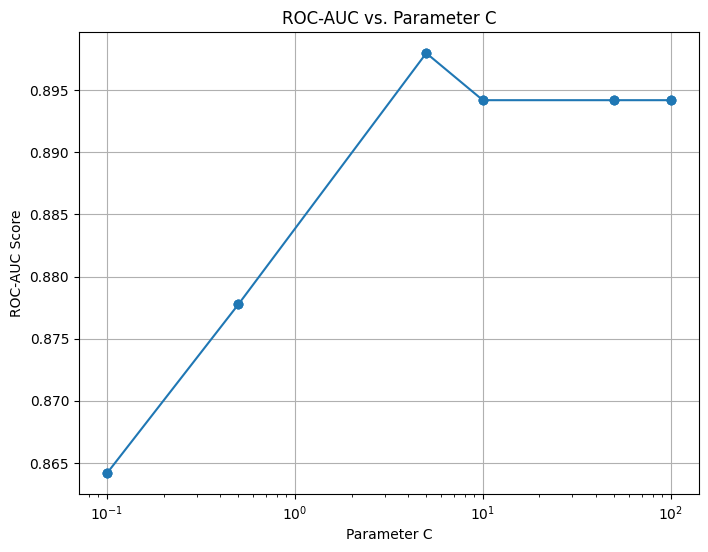

In [210]:
# Extract the results from the grid search
results = grid_search.cv_results_

# Get unique C values and corresponding mean test scores
C_values = results['param_C'].data.astype(float)  # Access 'param_C' to get C values directly
roc_auc_scores = results['mean_test_score']

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(C_values, roc_auc_scores, marker='o')
plt.xscale('log')  # Use a logarithmic scale for the x-axis (C values)
plt.xlabel('Parameter C')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC vs. Parameter C')
plt.grid(True)
plt.show()


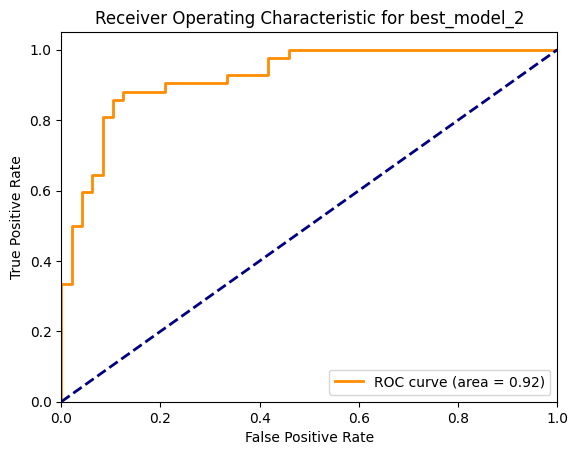

In [211]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_prob = best_model_1.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for best_model_2')
plt.legend(loc="lower right")
plt.show()

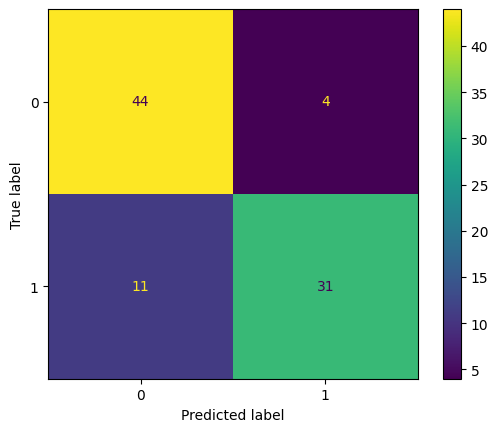

In [212]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

# Predict class labels for the test set
y_pred = best_model_1.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot()
plt.show()

In [213]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Predict class labels for the test set
y_pred = best_model_1.predict(X_test)

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Calculate test error (misclassification rate)
test_error = 1 - accuracy_score(y_test, y_pred)

# Create a table
data = {'Metric': ['Precision', 'Recall', 'Test Error'],
        'Value': [precision, recall, test_error]}
df_table = pd.DataFrame(data)
df_table

,Metric,Value
0,Precision,0.885714
1,Recall,0.738095
2,Test Error,0.166667


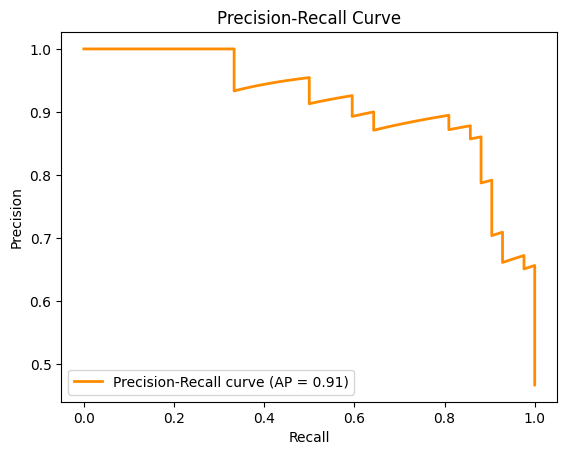

In [214]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Assuming 'best_model_2', 'X_test', and 'y_test' are defined from the previous code

# Predict probabilities for the positive class
y_pred_prob = best_model_1.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred_prob)


# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

## Processing 2

In [215]:
column_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
df_hung = pd.read_csv('processed.hungarian.data', names=column_names, na_values="?")
df_va = pd.read_csv('processed.va.data', names=column_names, na_values="?")
df_clv = pd.read_csv('processed.cleveland.data', names=column_names, na_values="?")
df_sws = pd.read_csv('processed.switzerland.data', names=column_names, na_values="?")

df = pd.concat([df_va, df_hung, df_clv, df_sws], ignore_index=True)
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
numeric_cols = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Define categorical columns (excluding the target variable)
categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]

# Fill null values in categorical columns with "Unknown"
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")

for col in categorical_cols:
    if "Unknown" in df[col].unique():
        df.loc[df[col] == "Unknown", col] = df[col].nunique() +1
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [216]:
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
df[categorical_features] = df[categorical_features].astype("category")
continuous_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

In [217]:
y = df['target']

# Set the remaining variables as the predictor matrix (X)
X = df.drop('target', axis=1)

In [218]:
# prompt: drop all columns besides '"target" and these ['cp', 'oldpeak', 'thalach', 'thal', 'ca', 'fbs', 'sex', 'slope'] from df_train and df_test

cols_to_keep = ['cp', 'oldpeak', 'thalach', 'thal', 'ca', 'fbs', 'sex', 'slope']
X = X[cols_to_keep]

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [220]:
X_train.head()

,cp,oldpeak,thalach,thal,ca,fbs,sex,slope
547,2.0,-0.834397,2.008146,3,0.000000,0.0,1.0,1.0
454,4.0,1.064576,-1.494365,5,0.676375,0.0,1.0,2.0
512,3.0,-0.644500,0.057884,3,0.000000,0.0,0.0,1.0
293,3.0,-0.834397,-0.499333,5,0.676375,0.0,0.0,5.0
357,2.0,-0.834397,0.694705,5,0.676375,0.0,0.0,5.0


In [221]:
y_train.head()

,target
547,0
454,1
512,0
293,0
357,0


In [222]:
# Define the parameter grid for alpha
param_grid = {'C': [0.1, 0.5, 5, 10, 50, 100], 'max_iter': [1000, 5000, 10000]} # C is the inverse of alpha

# Initialize the logistic regression model with LASSO penalty
logreg_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)

# Perform grid search with 5-fold stratified cross-validation
grid_search = GridSearchCV(logreg_lasso, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameter and the corresponding score
print("Best hyperparameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train the model with the best hyperparameter
best_model_2 = grid_search.best_estimator_
best_model_2.fit(X_train, y_train)

Best hyperparameter: {'C': 5, 'max_iter': 10000}
Best score: 0.8891317733990147


LogisticRegression(C=5, max_iter=10000, penalty='l1', solver='liblinear')

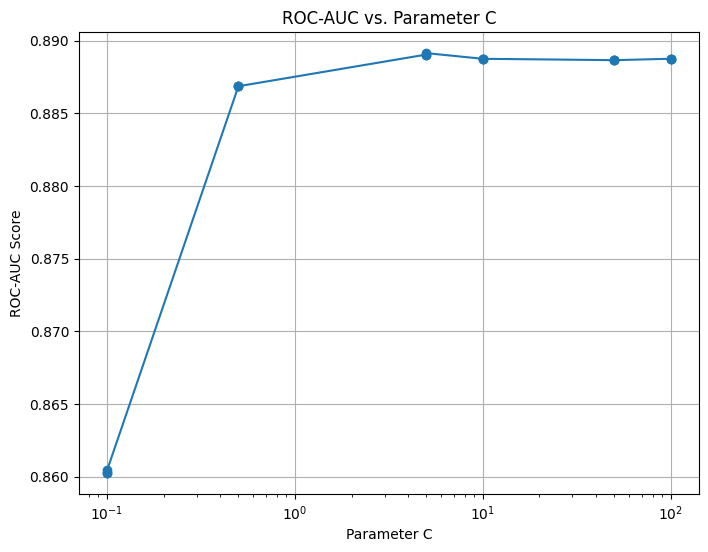

In [223]:
# Extract the results from the grid search
results = grid_search.cv_results_

# Get unique C values and corresponding mean test scores
C_values = results['param_C'].data.astype(float)  # Access 'param_C' to get C values directly
roc_auc_scores = results['mean_test_score']

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(C_values, roc_auc_scores, marker='o')
plt.xscale('log')  # Use a logarithmic scale for the x-axis (C values)
plt.xlabel('Parameter C')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC vs. Parameter C')
plt.grid(True)
plt.show()


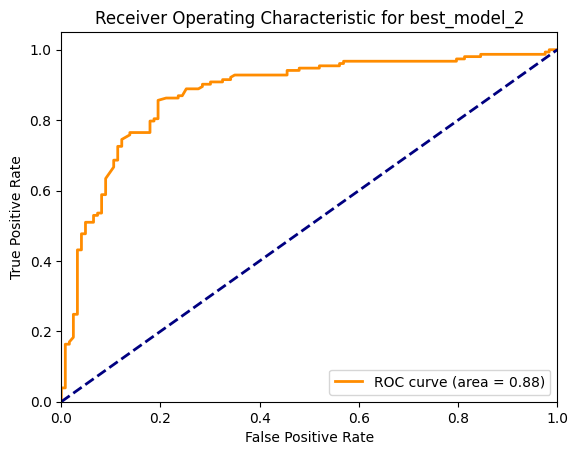

In [224]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_prob = best_model_2.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for best_model_2')
plt.legend(loc="lower right")
plt.show()


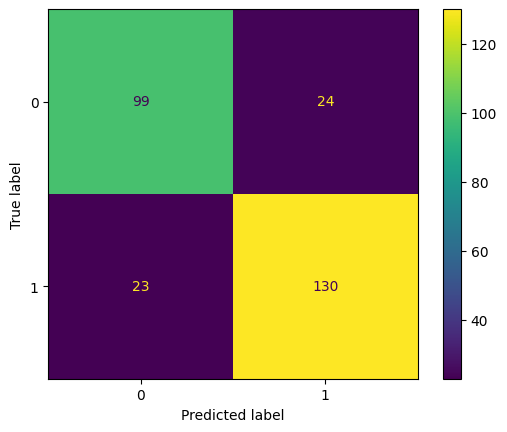

In [225]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

# Predict class labels for the test set
y_pred = best_model_2.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot()
plt.show()


In [226]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Predict class labels for the test set
y_pred = best_model_2.predict(X_test)

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Calculate test error (misclassification rate)
test_error = 1 - accuracy_score(y_test, y_pred)

# Create a table
data = {'Metric': ['Precision', 'Recall', 'Test Error'],
        'Value': [precision, recall, test_error]}
df_table = pd.DataFrame(data)
df_table


,Metric,Value
0,Precision,0.844156
1,Recall,0.849673
2,Test Error,0.170290


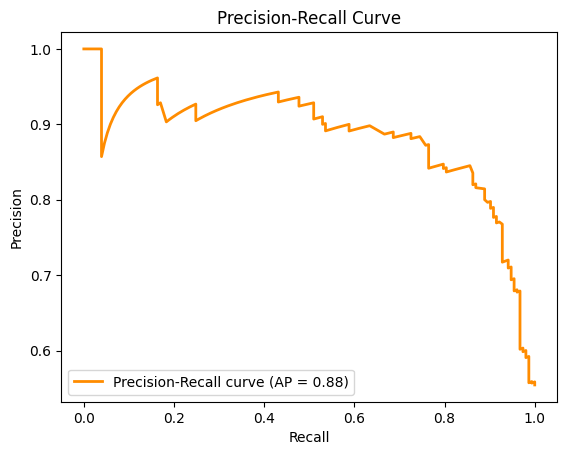

In [227]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Assuming 'best_model_2', 'X_test', and 'y_test' are defined from the previous code

# Predict probabilities for the positive class
y_pred_prob = best_model_2.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred_prob)


# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
